In [706]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd

## Pull in Dataset

Pull in the dataset and see what we are working with

In [708]:
df = pd.read_parquet("C:/Users/Kevin/Downloads/rentals.parquet")

rentals_df = df

In [709]:
# Inspect the Data
rentals_df.shape
rentals_df.info()
rentals_df.head()
rentals_df.describe(include='all')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258740 entries, 0 to 1258739
Data columns (total 9 columns):
 #   Column                                 Non-Null Count    Dtype         
---  ------                                 --------------    -----         
 0   Region ID                              1258740 non-null  object        
 1   Size Rank                              1258740 non-null  int32         
 2   Region                                 1258740 non-null  object        
 3   Region Type                            1258740 non-null  int64         
 4   State                                  1101168 non-null  object        
 5   Home Type                              1258740 non-null  int64         
 6   Date                                   1258740 non-null  datetime64[ms]
 7   Rent (Smoothed)                        532404 non-null   float32       
 8   Rent (Smoothed) (Seasonally Adjusted)  532295 non-null   float32       
dtypes: datetime64[ms](1), float32(2), in

,Region ID,Size Rank,Region,Region Type,State,Home Type,Date,Rent (Smoothed),Rent (Smoothed) (Seasonally Adjusted)
count,1258740,1.258740e+06,1258740,1.258740e+06,1101168,1.258740e+06,1258740,532404.000000,532295.000000
unique,10769,NaN,10139,NaN,781,NaN,NaN,NaN,NaN
top,394681,NaN,Jefferson County,NaN,Los Angeles County,NaN,NaN,NaN,NaN
freq,324,NaN,1296,NaN,32292,NaN,NaN,NaN,NaN
mean,NaN,2.896701e+03,NaN,8.018876e-01,NaN,3.772630e+00,2019-07-16 05:33:20,1653.195557,1648.511475
min,NaN,0.000000e+00,NaN,0.000000e+00,NaN,0.000000e+00,2015-01-31 00:00:00,470.475464,470.475464
25%,NaN,5.550000e+02,NaN,0.000000e+00,NaN,4.000000e+00,2017-04-22 12:00:00,1168.490967,1166.910645
50%,NaN,1.867000e+03,NaN,0.000000e+00,NaN,4.000000e+00,2019-07-15 12:00:00,1487.520996,1484.035034
75%,NaN,4.363000e+03,NaN,1.000000e+00,NaN,4.000000e+00,2021-10-07 18:00:00,1934.614014,1929.335938
max,NaN,3.049000e+04,NaN,5.000000e+00,NaN,4.000000e+00,2023-12-31 00:00:00,117500.000000,117500.000000


In [710]:
# Check for missing values
rentals_df.isnull().sum().sort_values(ascending=False)

Rent (Smoothed) (Seasonally Adjusted)    726445
Rent (Smoothed)                          726336
State                                    157572
Region ID                                     0
Size Rank                                     0
Region                                        0
Region Type                                   0
Home Type                                     0
Date                                          0
dtype: int64

In [711]:
# Convert Date to Date Year and Month columns
rentals_df["date"] = pd.to_datetime(rentals_df["Date"], errors="coerce")
rentals_df["year"] = rentals_df["Date"].dt.year
rentals_df["month"] = rentals_df["Date"].dt.month

## State column 

It looks like the state column is not correct, we will have to find other data to work with in the dataset

In [712]:
rentals_df["State"].value_counts()

State
Los Angeles County    32292
Orange County         19008
Montgomery County     15552
Jefferson County      14688
Cook County           14580
                      ...  
Elmore County           108
Muskingum County        108
Fannin County           108
Mendocino County        108
Skamania County         108
Name: count, Length: 781, dtype: int64

In [713]:
rentals_df.head()

,Region ID,Size Rank,Region,Region Type,State,Home Type,Date,Rent (Smoothed),Rent (Smoothed) (Seasonally Adjusted),date,year,month
0,66,146,Ada County,2,Ada County,4,2015-01-31,927.493774,927.493774,2015-01-31,2015,1
1,66,146,Ada County,2,Ada County,4,2015-02-28,931.690613,931.690613,2015-02-28,2015,2
2,66,146,Ada County,2,Ada County,4,2015-03-31,932.568604,932.568604,2015-03-31,2015,3
3,66,146,Ada County,2,Ada County,4,2015-04-30,933.148132,933.148132,2015-04-30,2015,4
4,66,146,Ada County,2,Ada County,4,2015-05-31,941.045715,941.045715,2015-05-31,2015,5


# Mapping by different identifiers



In [715]:
# Lets figure out how much we have for each region type, the State column is based off of county but there are multiple counties with the same name
Region_Type_Map = {
    0: "zip",
    1: "city",
    2: "county",
    3: "msa"
}

#Map the region type to the region type column and make it a new column
rentals_df["region_type_str"] = rentals_df["Region Type"].map(Region_Type_Map)

#count each value in the column
rentals_df["region_type_str"].value_counts()

region_type_str
zip       674136
city      318060
msa       157248
county    108972
Name: count, dtype: int64

In [716]:
#Make columns for the region type 
rentals_df['zip_code'] = None
rentals_df['city_name'] = None
rentals_df['county_name'] = None
rentals_df['msa_name'] = None

# Fill based on region_type_str
rentals_df.loc[rentals_df["region_type_str"] == "zip", "zip_code"] = rentals_df["Region"].astype(str).str.zfill(5)
rentals_df.loc[rentals_df["region_type_str"] == "city", "city_name"] = rentals_df["Region"].str.title().str.strip()
rentals_df.loc[rentals_df["region_type_str"] == "county", "county_name"] = rentals_df["Region"].str.replace(" County", "", regex=False).str.title().str.strip()
rentals_df.loc[rentals_df["region_type_str"] == "msa", "msa_name"] = rentals_df["Region"].str.title().str.strip()

In [717]:
# Keep full dataset for now
df_full = rentals_df.copy()

In [728]:
# Drop NA rent columns
df_rent = df_full.dropna(subset=["Rent (Smoothed)", "Rent (Smoothed) (Seasonally Adjusted)"]).copy()

df_rent["region_type_str"].value_counts()

region_type_str
zip       259086
city      128482
msa        83344
county     61016
Name: count, dtype: int64

In [729]:
#Sanity Check
df_rent[["State", "Rent (Smoothed)", "Rent (Smoothed) (Seasonally Adjusted)"]].isna().sum()

State                                    83668
Rent (Smoothed)                              0
Rent (Smoothed) (Seasonally Adjusted)        0
dtype: int64

In [730]:
# Make a region key that will help with EDA to identify different regions based on different metrics

def make_region_key(row):
    region_type = row["region_type_str"]
    region = str(row["Region"]).strip().lower()
    region_id = str(row["Region ID"]).strip()

    if region_type == "zip":
        region = region.zfill(5)
        return f"zip_{region}_{region_id}"
    elif region_type == "city":
        return f"city_{region.replace(' ', '_')}_{region_id}"
    elif region_type == "county":
        return f"count_{region.replace(' county', '').replace(' ', '_')}_{region_id}"
    elif region_type == "msa":
        return f"msa_{region.replace(',', '').replace(' ', '_')}_{region_id}"
    else:
        return f"other_{region}_{region_id}"

df_rent["region_key"] = df_rent.apply(make_region_key, axis=1)


In [731]:
# Monthly rent by region_key
df_rent["Month"] = df_rent["Date"].dt.to_period("M")
monthly = (
    df_rent[df_rent["region_type_str"] == "zip"]
    .groupby(["region_key", "Month"])["Rent (Smoothed)"]
    .mean()
    .reset_index()
)
monthly["Month"] = monthly["Month"].dt.to_timestamp()

# Calculate % change in rent
monthly["rent_delta_pct"] = (
    monthly.groupby("region_key")["Rent (Smoothed)"].pct_change() * 100
)

# Label pre- vs post-COVID
monthly["era"] = monthly["Month"].apply(
    lambda d: "pre" if d < pd.to_datetime("2020-03-01") else "post"
)

# Compute volatility per region
region_vol = (
    monthly.groupby(["region_key", "era"])["rent_delta_pct"]
    .std()
    .unstack()
    .dropna()
    .rename(columns={"pre": "pre_vol", "post": "post_vol"})
)

# Compute volatility change
region_vol["volatility_change"] = region_vol["post_vol"] - region_vol["pre_vol"]
region_vol_sorted = region_vol.sort_values("volatility_change", ascending=False)


## Exploratory Data Analysis

Here we will explore the differen aspects of the data

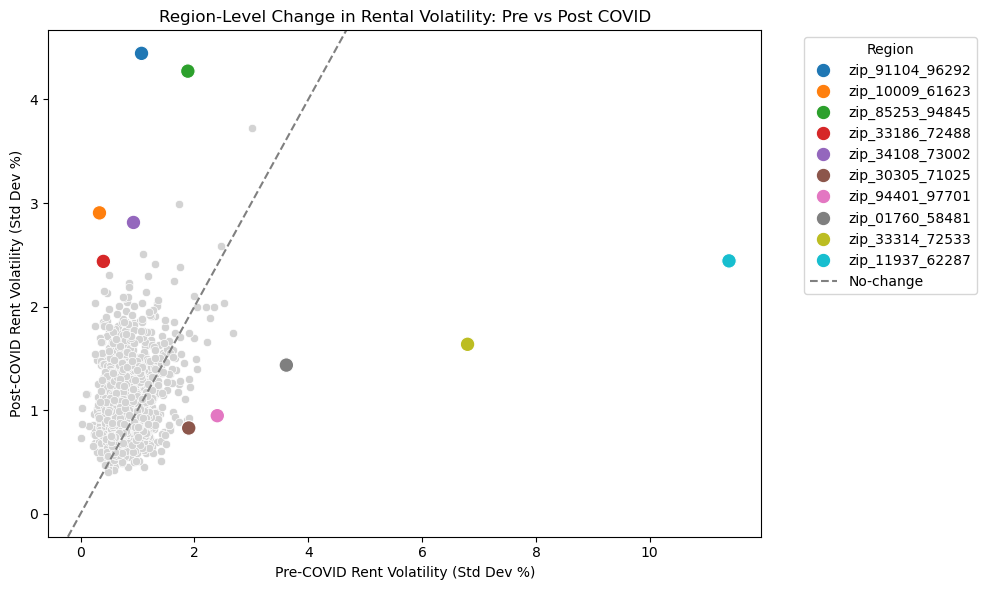

In [734]:

# get top 5 and bottom 5 by volatility
top5 = region_vol_sorted.head(5)
bottom5 = region_vol_sorted.tail(5)
hilite = pd.concat([top5, bottom5])

# plot the figures
plt.figure(figsize=(10,6))
sns.scatterplot(data=region_vol, x="pre_vol", y="post_vol", color="lightgray")
sns.scatterplot(data=hilite, x="pre_vol", y="post_vol",
                hue=hilite.index, s=110, palette="tab10")

plt.axline((0,0), slope=1, ls="--", color="gray", label="No-change")
plt.xlabel("Pre-COVID Rent Volatility (Std Dev %)")
plt.ylabel("Post-COVID Rent Volatility (Std Dev %)")
plt.title("Region-Level Change in Rental Volatility: Pre vs Post COVID")
plt.legend(title="Region", bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout()
plt.show()


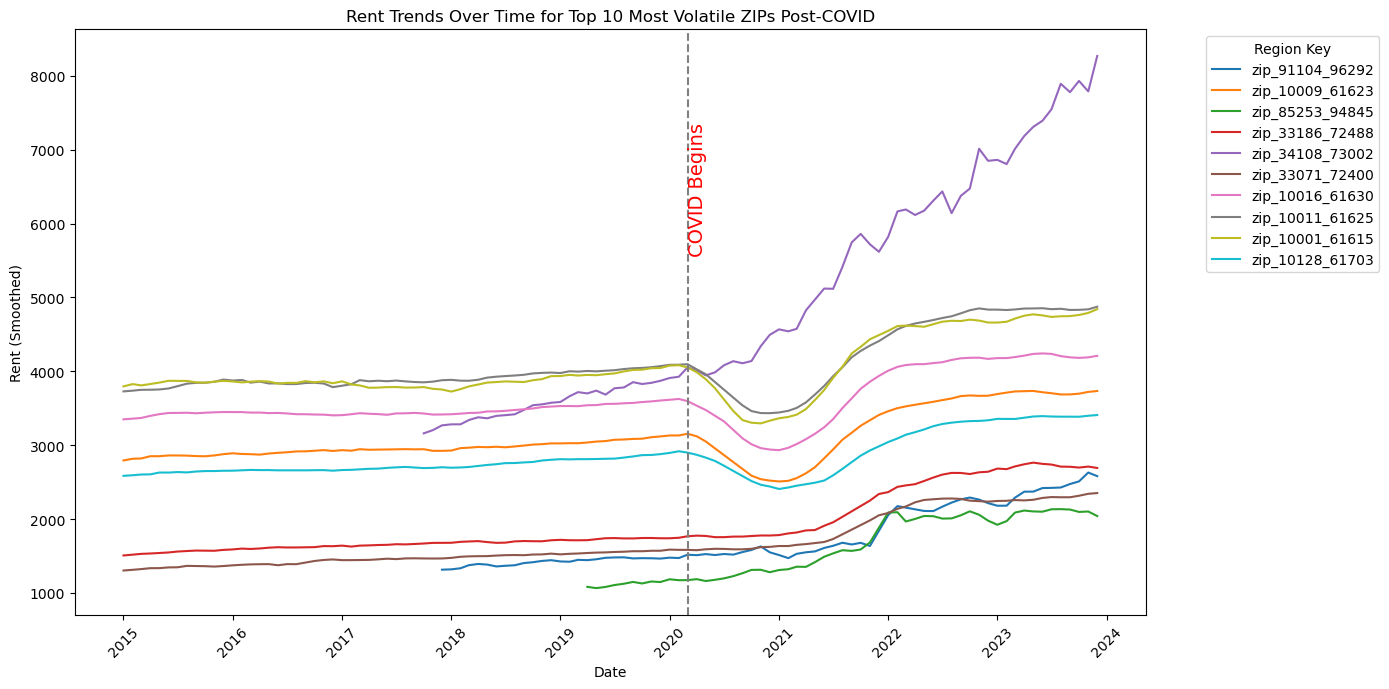

In [738]:
# Get the top 10 most volatile ZIPs by volatility change
top10_keys = region_vol_sorted.head(10).index.tolist()

plt.figure(figsize=(14, 7))

# Loop through each ZIP and plot their rent trend
for key in top10_keys:
    subset = df_rent[(df_rent["region_key"] == key)].copy()
    subset["Month"] = subset["Date"].dt.to_period("M")
    monthly_rent = (
        subset.groupby("Month")["Rent (Smoothed)"]
        .mean()
        .reset_index()
    )
    monthly_rent["Month"] = monthly_rent["Month"].dt.to_timestamp()
    plt.plot(monthly_rent["Month"], monthly_rent["Rent (Smoothed)"], label=key)

# Customize the plot
plt.title("Rent Trends Over Time for Top 10 Most Volatile ZIPs Post-COVID")
plt.xlabel("Date")
plt.ylabel("Rent (Smoothed)")
plt.legend(title="Region Key", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=45)
plt.axvline(pd.to_datetime("2020-03-01"), color="gray", linestyle="--", linewidth=1.5, label="COVID Begins")
plt.tight_layout()
plt.text(pd.to_datetime("2020-03-01"),plt.ylim()[1]*0.65, "COVID Begins", rotation=90, color="red",fontsize=14)
plt.show()


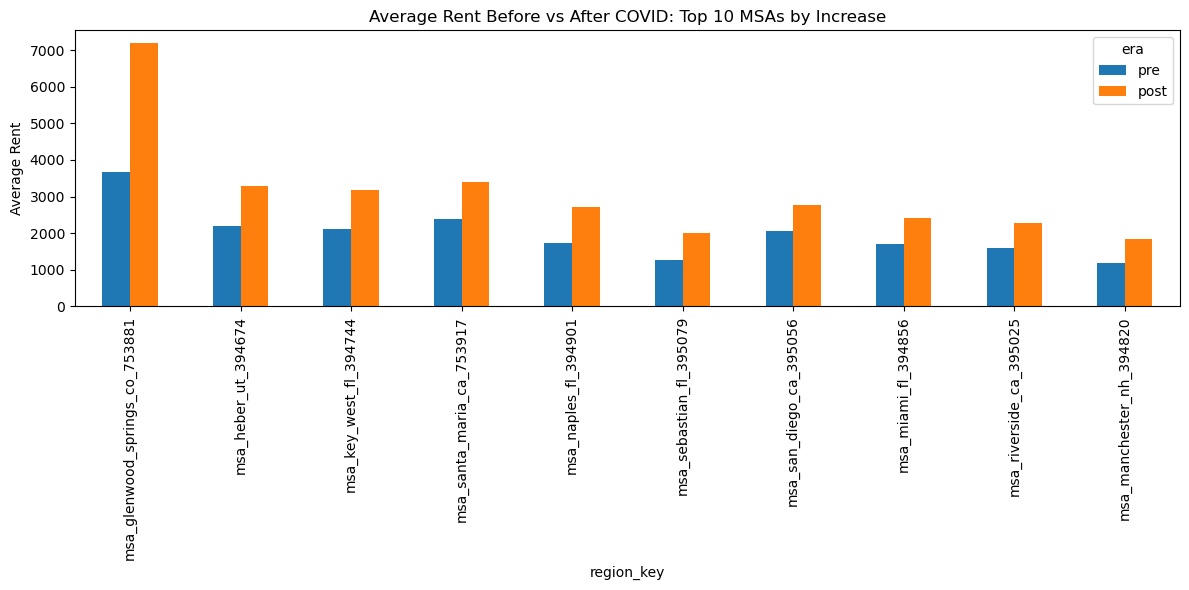

In [739]:
# Filter to MSA-level only
df_msa = df_rent[df_rent["region_type_str"] == "msa"].copy()

# Label pre/post COVID
df_msa["era"] = df_msa["Date"].apply(lambda d: "pre" if d < pd.to_datetime("2020-03-01") else "post")

# Group by era and region
msa_avg_rent = (
    df_msa.groupby(["region_key", "era"])["Rent (Smoothed)"]
    .mean()
    .unstack()
    .dropna()
)

msa_avg_rent["delta"] = msa_avg_rent["post"] - msa_avg_rent["pre"]
msa_top10 = msa_avg_rent.sort_values("delta", ascending=False).head(10)

# Plot
msa_top10[["pre", "post"]].plot(kind="bar", figsize=(12, 6))
plt.title("Average Rent Before vs After COVID: Top 10 MSAs by Increase")
plt.ylabel("Average Rent")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [742]:
df_msa["Month"] = df_msa["Date"].dt.to_period("M")
monthly_msa = (
    df_msa.groupby(["region_key", "Month"])["Rent (Smoothed)"]
    .mean()
    .reset_index()
)
monthly_msa["Month"] = monthly_msa["Month"].dt.to_timestamp()
monthly_msa["rent_delta_pct"] = (
    monthly_msa.groupby("region_key")["Rent (Smoothed)"].pct_change() * 100
)

# Label pre/post
monthly_msa["era"] = monthly_msa["Month"].apply(
    lambda d: "pre" if d < pd.to_datetime("2020-03-01") else "post"
)

# Aggregate growth rate std dev
growth_by_msa = (
    monthly_msa.groupby(["region_key", "era"])["rent_delta_pct"]
    .std()
    .unstack()
    .dropna()
    .rename(columns={"pre": "pre_vol", "post": "post_vol"})
)
growth_by_msa["delta"] = growth_by_msa["post_vol"] - growth_by_msa["pre_vol"]

national_avg_delta = growth_by_msa["delta"].mean()


C:\Users\Kevin\AppData\Local\Temp\ipykernel_20964\3122925095.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(top_vol_delta_sorted.index.astype(str), rotation=90)


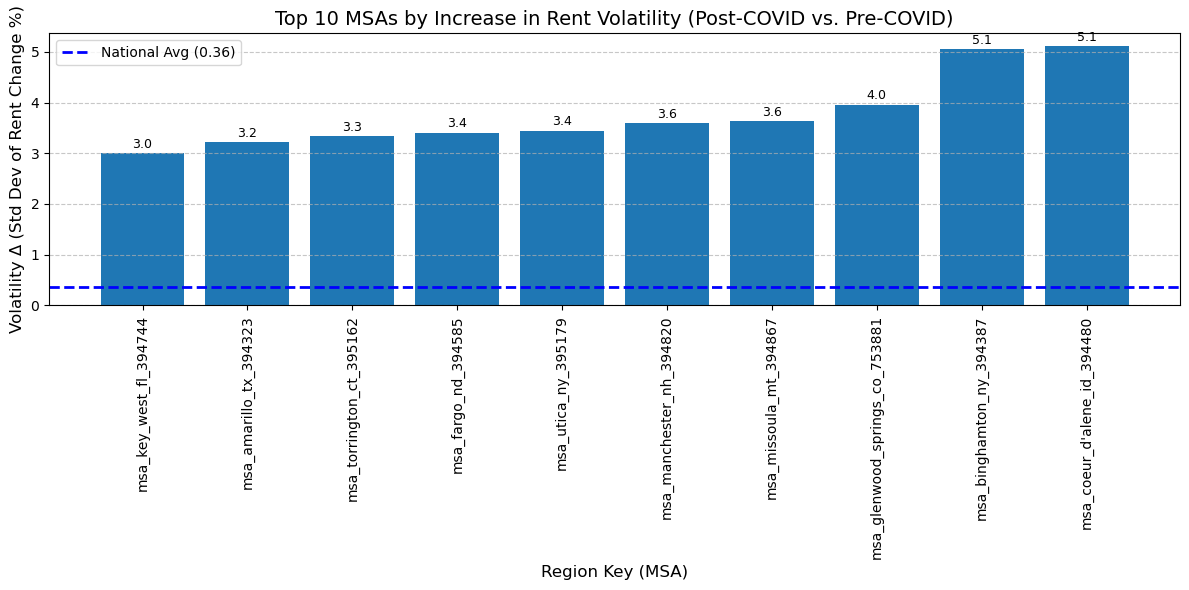

In [744]:
import matplotlib.pyplot as plt

# Calculate national average delta
national_avg_delta = growth_by_msa["delta"].mean()

# Sort and select top 10
top_vol_delta = growth_by_msa.sort_values("delta", ascending=False).head(10)
top_vol_delta_sorted = top_vol_delta.sort_values("delta")

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(top_vol_delta_sorted.index.astype(str), top_vol_delta_sorted["delta"])

# Labels and titles
ax.set_title("Top 10 MSAs by Increase in Rent Volatility (Post-COVID vs. Pre-COVID)", fontsize=14)
ax.set_xlabel("Region Key (MSA)", fontsize=12)
ax.set_ylabel("Volatility Δ (Std Dev of Rent Change %)", fontsize=12)
ax.set_xticklabels(top_vol_delta_sorted.index.astype(str), rotation=90)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# National average line
ax.axhline(national_avg_delta, color='blue', linestyle='--', linewidth=2, label=f"National Avg ({national_avg_delta:.2f})")
ax.legend()

# Annotate bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.05, f'{height:.1f}',
            ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()



## ZIP Code to FIPS code

Here we are changing the zip code to a fips code to standardize the data set. This will help with county level metrics


In [746]:
# Read in the zip code to FIPS code datasheet
zips_fips_df = pd.read_csv("C:\\Users\\Kevin\\Downloads\\Copy of ZIP Code Data and Mapping U.S. Locations - ZIP to County.csv" )

In [748]:
df_rent.head()

,Region ID,Size Rank,Region,Region Type,State,Home Type,Date,Rent (Smoothed),Rent (Smoothed) (Seasonally Adjusted),date,year,month,region_type_str,zip_code,city_name,county_name,msa_name,region_key,Month
0,66,146,Ada County,2,Ada County,4,2015-01-31,927.493774,927.493774,2015-01-31,2015,1,county,None,None,Ada,None,count_ada_66,2015-01
1,66,146,Ada County,2,Ada County,4,2015-02-28,931.690613,931.690613,2015-02-28,2015,2,county,None,None,Ada,None,count_ada_66,2015-02
2,66,146,Ada County,2,Ada County,4,2015-03-31,932.568604,932.568604,2015-03-31,2015,3,county,None,None,Ada,None,count_ada_66,2015-03
3,66,146,Ada County,2,Ada County,4,2015-04-30,933.148132,933.148132,2015-04-30,2015,4,county,None,None,Ada,None,count_ada_66,2015-04
4,66,146,Ada County,2,Ada County,4,2015-05-31,941.045715,941.045715,2015-05-31,2015,5,county,None,None,Ada,None,count_ada_66,2015-05


In [750]:
# change both ZIP columns to strings
df_rent["Region"] = df_rent["Region"].astype(str).str.zfill(5)
zips_fips_df["ZIP"] = zips_fips_df["ZIP"].astype(str).str.zfill(5)
zips_fips_df["COUNTY Code"] = zips_fips_df["COUNTY Code"].astype(str).str.zfill(5)

In [752]:
zips_fips_df[['ZIP','COUNTY Code']].sample(15)

,ZIP,COUNTY Code
36211,43331,39011
52321,25557,54099
514,35956,01095
32457,12861,36115
34565,28150,37045
3423,91748,06037
24924,56563,27027
38731,74350,40035
44799,38006,47075
24171,55941,27055


In [755]:
print(zips_fips_df["ZIP"].str.len().value_counts())

ZIP
5    54553
Name: count, dtype: int64


## Merge the two datasets together to get FIPS data on our main dataset

In [757]:
df_rent = df_rent.merge(zips_fips_df, how='left', left_on ='Region', right_on= 'ZIP')


In [759]:
df_rent["COUNTY Code"] =df_rent["COUNTY Code"].astype(str).str.zfill(5)

In [763]:
print(f"Merged rows: {len(df_rent)}")
print(f"Rows with FIPS assigned: {df_rent['COUNTY Code'].notna().sum()}")

Merged rows: 593360
Rows with FIPS assigned: 593360


In [765]:
#Take a random sample and do a quick spot check to verify that the zip code and FIPS are accurate
df_rent[['Region','ZIP', 'COUNTY Code']].sample(15)

,Region,ZIP,COUNTY Code
293240,33162,33162,12086
5091,Wood County,NaN,00nan
481884,95691,95691,06113
591466,Lancaster,NaN,00nan
218422,20009,20009,11001
491254,98026,98026,53061
410527,80110,80110,08005
260652,30052,30052,13247
325953,43224,43224,39049
580141,"Winchester, VA",NaN,00nan


In [767]:
df_rent[["Region", "COUNTY Code"]].isnull().sum()

Region         0
COUNTY Code    0
dtype: int64

In [769]:
df_rent.isnull().sum().sort_values(ascending=False)

county_name                              532344
msa_name                                 510016
city_name                                464878
ZIP Code Population                      273171
zip_code                                 273166
# of Counties                            273166
% of ZIP Residents in County             273166
State Abbreviation                       273166
County State                             273166
County                                   273166
USPS Default State for ZIP               273166
ZIP                                      273166
USPS Default City for ZIP                273166
State                                     83668
region_type_str                             324
Size Rank                                     0
month                                         0
year                                          0
region_key                                    0
Month                                         0
date                                    

In [773]:
# Now we will include the population metrics into our dataframe, lets load the datasets 
# from the US Census. We will load both of those below and see what columns are available
# Once we do this we will extract the columns we need

pop_df_18_19 = pd.read_csv("C:\\Users\\Kevin\\Downloads\\co-est2019-alldata.csv", encoding='latin1')

In [775]:
# Extract the columns needed form 2018-2019 populaiton estimates
cols_needed = ['STATE', 'COUNTY', 'POPESTIMATE2018','POPESTIMATE2019', 'STNAME', 'CTYNAME']
population_df_18_19 = pop_df_18_19[cols_needed]

In [777]:
population_df_18_19['FIPS'] = population_df_18_19['STATE'].astype(str).str.zfill(2) + population_df_18_19['COUNTY'].astype(str).str.zfill(3)

C:\Users\Kevin\AppData\Local\Temp\ipykernel_20964\2504839668.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  population_df_18_19['FIPS'] = population_df_18_19['STATE'].astype(str).str.zfill(2) + population_df_18_19['COUNTY'].astype(str).str.zfill(3)


In [779]:
# Quick check to see if they are correct
population_df_18_19[['STATE', 'COUNTY','FIPS']].sample(10)

,STATE,COUNTY,FIPS
530,13,269,13269
420,13,47,13047
1252,25,27,25027
2158,39,159,39159
3153,55,111,55111
705,17,193,17193
44,1,87,01087
98,4,0,04000
2310,42,55,42055
977,20,145,20145


## Population Dataset

Lets get population data and merge it into our main dataaset

In [781]:
# Read in the population level data from 2020-2024
pop_df_22_23 = pd.read_csv('C:\\Users\\Kevin\\Downloads\\co-est2024-alldata.csv', encoding = "ISO-8859-1", engine='python',
                       dtype={'STATE': str, 'COUNTY' : str})

In [783]:
columns_needed = ['STATE', 'COUNTY', 'POPESTIMATE2020','POPESTIMATE2021','POPESTIMATE2022', 'POPESTIMATE2023', 'STNAME', 'CTYNAME']
population_df_22_23 = pop_df_22_23[columns_needed]                  

In [785]:
#Concatenate the FIPS for state and COunty
population_df_22_23['FIPS'] = population_df_22_23['STATE'].astype(str).str.zfill(2) + population_df_22_23['COUNTY'].astype(str).str.zfill(3)

C:\Users\Kevin\AppData\Local\Temp\ipykernel_20964\2252444057.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  population_df_22_23['FIPS'] = population_df_22_23['STATE'].astype(str).str.zfill(2) + population_df_22_23['COUNTY'].astype(str).str.zfill(3)


In [787]:
population_df_22_23[['STATE', 'COUNTY','FIPS']].sample(10)

,STATE,COUNTY,FIPS
1476,28,097,28097
946,20,079,20079
2050,38,047,38047
870,19,127,19127
445,13,093,13093
2336,42,103,42103
3054,54,023,54023
1765,31,163,31163
1891,36,057,36057
2446,46,083,46083


In [789]:
population_df_22_23.head(10)

,STATE,COUNTY,POPESTIMATE2020,POPESTIMATE2021,POPESTIMATE2022,POPESTIMATE2023,STNAME,CTYNAME,FIPS
0,01,000,5033094,5049196,5076181,5117673,Alabama,Alabama,01000
1,01,001,58909,59191,59736,60436,Alabama,Autauga County,01001
2,01,003,233244,239411,246577,254107,Alabama,Baldwin County,01003
3,01,005,24975,24517,24722,24644,Alabama,Barbour County,01005
4,01,007,22176,22344,21983,21890,Alabama,Bibb County,01007
5,01,009,59110,59050,59491,59777,Alabama,Blount County,01009
6,01,011,10230,10126,10126,9908,Alabama,Bullock County,01011
7,01,013,19027,18856,18652,18357,Alabama,Butler County,01013
8,01,015,116242,115633,115744,116403,Alabama,Calhoun County,01015
9,01,017,34572,34396,34093,34087,Alabama,Chambers County,01017


In [790]:
# Lets get rid of the data from the State population levels with County code 000 since we are doing a county level assesment
population_df_18_19 = population_df_18_19[population_df_18_19['COUNTY'] != '000']
population_df_22_23 = population_df_22_23[population_df_22_23['COUNTY'] != '000']

In [793]:
df_rent['FIPS'] = df_rent['COUNTY Code']

df_rent = df_rent[df_rent['region_type_str'] == 'zip'].copy()

In [795]:
merged_df = df_rent.merge(population_df_18_19, on='FIPS', how='left')

In [797]:
merged_df = merged_df.merge(population_df_22_23, on='FIPS', how='left')

In [799]:
for col in merged_df:
    print(col)

Region ID
Size Rank
Region
Region Type
State
Home Type
Date
Rent (Smoothed)
Rent (Smoothed) (Seasonally Adjusted)
date
year
month
region_type_str
zip_code
city_name
county_name
msa_name
region_key
Month
ZIP
USPS Default State for ZIP
County
County State
State Abbreviation
COUNTY Code
ZIP Code Population
% of ZIP Residents in County
# of Counties
USPS Default City for ZIP
FIPS
STATE_x
COUNTY_x
POPESTIMATE2018
POPESTIMATE2019
STNAME_x
CTYNAME_x
STATE_y
COUNTY_y
POPESTIMATE2020
POPESTIMATE2021
POPESTIMATE2022
POPESTIMATE2023
STNAME_y
CTYNAME_y


In [801]:
# lets clean up some of the redundant column names
merged_df.drop(columns=['STATE_y', 'COUNTY_y', 'STNAME_y', 'CTYNAME_y'], inplace=True)

merged_df.rename(columns={
    'STATE_x': 'STATE',
    'COUNTY_x': 'COUNTY',
    'STNAME_x': 'STNAME',
    'CTYNAME_x': 'CTYNAME'
}, inplace=True)


## Shapefile Data

Get the data for the shapefile to get area of land for the dataset

In [803]:
# lets bring in a dataframe to for area land of the United States (continguous) this way we can calculate pop density
us_gdf = gpd.read_file('C:\\Users\\Kevin\\Downloads\\cb_2024_us_county_500k\\cb_2024_us_county_500k.shp')
#States to filter out
exclude_states = ['15','02','72','66','69','60','78']
# Actaul filter
us_gdf_filter = us_gdf[~us_gdf['STATEFP'].isin(exclude_states)]
#Change CRS to epsg 5070
us_gdf_filter.to_crs(epsg=5070)

,STATEFP,COUNTYFP,COUNTYNS,GEOIDFQ,GEOID,NAME,NAMELSAD,STUSPS,STATE_NAME,LSAD,ALAND,AWATER,geometry
0,01,069,00161560,0500000US01069,01069,Houston,Houston County,AL,Alabama,06,1501742250,4795418,"POLYGON ((975267.981 955249.146, 975512.945 95..."
1,01,023,00161537,0500000US01023,01023,Choctaw,Choctaw County,AL,Alabama,06,2365900084,19114321,"POLYGON ((708032.013 1008009.585, 708119.103 1..."
2,01,113,00161583,0500000US01113,01113,Russell,Russell County,AL,Alabama,06,1660653961,15562947,"POLYGON ((987614.299 1082134.819, 986771.184 1..."
3,10,005,00217269,0500000US10005,10005,Sussex,Sussex County,DE,Delaware,06,2424590442,674129051,"POLYGON ((1730705.501 1941185.697, 1739623.244..."
4,01,071,00161561,0500000US01071,01071,Jackson,Jackson County,AL,Alabama,06,2792044612,126334711,"MULTIPOLYGON (((895011.35 1321054.818, 895405...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3230,31,161,00835902,0500000US31161,31161,Sheridan,Sheridan County,NE,Nebraska,06,6320009952,76575663,"POLYGON ((-551780.743 2222598.709, -550303.118..."
3231,17,119,00424258,0500000US17119,17119,Madison,Madison County,IL,Illinois,06,1853186559,63511490,"POLYGON ((491320.867 1782407.332, 491261.269 1..."
3232,28,155,00695798,0500000US28155,28155,Webster,Webster County,MS,Mississippi,06,1090793737,5364867,"POLYGON ((597014.788 1204295.641, 607433.752 1..."
3233,29,161,00758535,0500000US29161,29161,Phelps,Phelps County,MO,Missouri,06,1739921375,6564700,"POLYGON ((346713.218 1637213.23, 346863.895 16..."


In [805]:
# Combine the statefp and countyfp into a unified fips code
us_gdf['FIPS'] = us_gdf['STATEFP'].astype(str).str.zfill(2) + us_gdf['COUNTYFP'].astype(str).str.zfill(3)

In [807]:
# Keep only the FIPS ALAND and geometry columns
us_gdf = us_gdf[["FIPS", "ALAND", "geometry"]]

# Now merge it into your main dataframe
merged_df = merged_df.merge(us_gdf, on="FIPS", how="left")


In [809]:
df = pd.read_excel('C:\\Users\\Kevin\\Downloads\\laucnty18.xlsx', dtype={'State FIPS Code': str, 'County FIPS Code': str})

In [811]:
df.head()

,"Labor Force Data by County, 2018 Annual Averages",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,LAUS Code,State FIPS Code,County FIPS Code,County Name/State Abbreviation,Year,Labor Force,Employed,Unemployed,Unemployment Rate (%)
1,CN0100100000000,01,001,"Autauga County, AL",2018,26498,25535,963,3.6
2,CN0100300000000,01,003,"Baldwin County, AL",2018,103587,100126,3461,3.3
3,CN0100500000000,01,005,"Barbour County, AL",2018,9387,8947,440,4.7
4,CN0100700000000,01,007,"Bibb County, AL",2018,8710,8369,341,3.9


##  Unemployement Data

Get the unemployment data and merge it into the main dataset. We will do this for each year, by making a function for the year and grabbing that and merge by FIPS data

In [813]:
# Now lets get the unemployment data from each year of 2018 - 2022
# We will do a function here to make things a lot easierimport pandas as pd

def load_and_merge_unemployment(year, merged_df):
    
    file_path = f"C:\\Users\\Kevin\\Downloads\\laucnty{year}.xlsx"
    
    # Load the data
    df = pd.read_excel(file_path,skiprows=1, dtype={'State FIPS Code': str, 'County FIPS Code': str})
    
    # Create full FIPS code
    df['FIPS'] = df['State FIPS Code'].str.zfill(2) + df['County FIPS Code'].str.zfill(3)
    
    # Rename unemployment rate column
    df.rename(columns={'Unemployment Rate (%)': f'unemp_{year}'}, inplace=True)
    
    # Keep only FIPS and unemployment column
    df = df[['FIPS', f'unemp_{year}']]
    
    # Merge into your main dataframe
    merged_df = merged_df.merge(df, on='FIPS', how='left')
    
    return merged_df


In [815]:
for year in range(18, 23):
    merged_df = load_and_merge_unemployment(year, merged_df)

In [817]:
for col in merged_df:
    print(col)


Region ID
Size Rank
Region
Region Type
State
Home Type
Date
Rent (Smoothed)
Rent (Smoothed) (Seasonally Adjusted)
date
year
month
region_type_str
zip_code
city_name
county_name
msa_name
region_key
Month
ZIP
USPS Default State for ZIP
County
County State
State Abbreviation
COUNTY Code
ZIP Code Population
% of ZIP Residents in County
# of Counties
USPS Default City for ZIP
FIPS
STATE
COUNTY
POPESTIMATE2018
POPESTIMATE2019
STNAME
CTYNAME
POPESTIMATE2020
POPESTIMATE2021
POPESTIMATE2022
POPESTIMATE2023
ALAND
geometry
unemp_18
unemp_19
unemp_20
unemp_21
unemp_22


## Housing Units

Grab housing units data and input into our dataset

In [849]:
housing_units_20_22 = pd.read_excel('C:\\Users\\Kevin\\Downloads\\CO-EST2024-HU.xlsx', skiprows=3)

In [851]:
#rename column for county and state
housing_units_20_22.rename(columns={housing_units_20_22.columns[0]: 'Location'}, inplace = True)

In [853]:
# Drop all rows that are not counties (United States)
housing_units_20_22 = housing_units_20_22[housing_units_20_22["Location"].str.contains(",", na=False)]

In [855]:
has_comma = housing_units_20_22['Location'].str.contains(",", na=False)
split_df = housing_units_20_22.loc[has_comma, 'Location'].str.split(',', expand=True)
# split location into ca=onty and state
housing_units_20_22.loc[has_comma, 'County'] = split_df[0].str.strip()
housing_units_20_22.loc[has_comma, 'State'] = split_df[1].str.strip()

C:\Users\Kevin\AppData\Local\Temp\ipykernel_20964\1465868950.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housing_units_20_22.loc[has_comma, 'County'] = split_df[0].str.strip()
C:\Users\Kevin\AppData\Local\Temp\ipykernel_20964\1465868950.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housing_units_20_22.loc[has_comma, 'State'] = split_df[1].str.strip()


In [857]:
housing_units_20_22['County'] = housing_units_20_22['County'].str.lstrip('.').str.strip()


C:\Users\Kevin\AppData\Local\Temp\ipykernel_20964\3077025873.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housing_units_20_22['County'] = housing_units_20_22['County'].str.lstrip('.').str.strip()


In [859]:
housing_units_20_22.head(10)

,Location,Unnamed: 1,2020,2021,2022,2023,2024,County,State
1,".Autauga County, Alabama",24349.0,24412.0,24760.0,25102.0,25311.0,25608.0,Autauga County,Alabama
2,".Baldwin County, Alabama",124149.0,124917.0,128472.0,132223.0,135634.0,140048.0,Baldwin County,Alabama
3,".Barbour County, Alabama",11618.0,11626.0,11671.0,11746.0,11803.0,11912.0,Barbour County,Alabama
4,".Bibb County, Alabama",9000.0,9011.0,9071.0,9146.0,9197.0,9244.0,Bibb County,Alabama
5,".Blount County, Alabama",24621.0,24645.0,24753.0,24938.0,25058.0,25177.0,Blount County,Alabama
6,".Bullock County, Alabama",4515.0,4520.0,4547.0,4592.0,4621.0,4655.0,Bullock County,Alabama
7,".Butler County, Alabama",9804.0,9809.0,9831.0,9876.0,9900.0,9943.0,Butler County,Alabama
8,".Calhoun County, Alabama",53048.0,53075.0,53189.0,53387.0,53517.0,53637.0,Calhoun County,Alabama
9,".Chambers County, Alabama",16347.0,16363.0,16390.0,16437.0,16476.0,16518.0,Chambers County,Alabama
10,".Cherokee County, Alabama",14516.0,14531.0,14604.0,14715.0,14821.0,14885.0,Cherokee County,Alabama


In [861]:
#read in our fips data to get our housing unit data to merge fips onto
zips_to_fips_df = pd.read_csv("C:\\Users\\Kevin\\Downloads\\county_fips_master.csv", encoding='latin1')

In [863]:
#strip and title case the columns
zips_to_fips_df = zips_to_fips_df[['county_name', 'state_name', 'fips']]
zips_to_fips_df['county_name'] = zips_to_fips_df['county_name'].str.strip().str.title()
zips_to_fips_df['state_name'] = zips_to_fips_df['state_name'].str.strip()

In [865]:
#strip and title case the columns in the housing units dataset
housing_units_20_22.loc[:, 'County'] = housing_units_20_22['County'].str.strip().str.title()
housing_units_20_22.loc[:, 'State'] = housing_units_20_22['State'].str.strip().str.title()

In [867]:
# merge the data onto each other Fips and housing units
housing_units_20_22 = housing_units_20_22.merge(zips_to_fips_df, left_on=['State', 'County'], right_on=['state_name', 'county_name'],how='left')

housing_units_20_22.head()


,Location,Unnamed: 1,2020,2021,2022,2023,2024,County,State,county_name,state_name,fips
0,".Autauga County, Alabama",24349.0,24412.0,24760.0,25102.0,25311.0,25608.0,Autauga County,Alabama,Autauga County,Alabama,1001.0
1,".Baldwin County, Alabama",124149.0,124917.0,128472.0,132223.0,135634.0,140048.0,Baldwin County,Alabama,Baldwin County,Alabama,1003.0
2,".Barbour County, Alabama",11618.0,11626.0,11671.0,11746.0,11803.0,11912.0,Barbour County,Alabama,Barbour County,Alabama,1005.0
3,".Bibb County, Alabama",9000.0,9011.0,9071.0,9146.0,9197.0,9244.0,Bibb County,Alabama,Bibb County,Alabama,1007.0
4,".Blount County, Alabama",24621.0,24645.0,24753.0,24938.0,25058.0,25177.0,Blount County,Alabama,Blount County,Alabama,1009.0


In [869]:
# Rename the housing columns
housing_units_20_22.rename(columns={
    2020: 'housing_units_2020',
    2021: 'housing_units_2021',
    2022: 'housing_units_2022',
    'fips': 'FIPS'
}, inplace=True)

In [871]:
# Convert the county code to fips 
housing_units_20_22['FIPS'] = housing_units_20_22['FIPS'].apply(
    lambda x: str(int(x)).zfill(5) if pd.notna(x) else None
)


In [873]:
housing_subset = housing_units_20_22[['FIPS', 'housing_units_2020', 'housing_units_2021', 'housing_units_2022']]
housing_subset = housing_subset.drop_duplicates(subset='FIPS')

In [875]:
dup_fips_filtered = housing_subset['FIPS'].duplicated().sum()
print(f"Duplicate FIPS rows in housing_subset: {dup_fips_filtered}")

Duplicate FIPS rows in housing_subset: 0


In [877]:
house_subset_20_22 = housing_units_20_22[['FIPS', 'housing_units_2020', 'housing_units_2021', 'housing_units_2022']]

merged_df = merged_df.merge(house_subset_20_22, on='FIPS', how='left')

In [883]:
housing_units_18_19 = pd.read_excel('C:\\Users\\Kevin\\Downloads\\CO-EST2019-ANNHU.xlsx', skiprows=3)

In [885]:
#rename column for county and state
housing_units_18_19.rename(columns={housing_units_18_19.columns[0]: 'Location'}, inplace = True)

In [887]:
# Drop all rows that are not counties (United States)
housing_units_18_19 = housing_units_18_19[housing_units_18_19["Location"].str.contains(",", na=False)]

In [889]:
has_comma = housing_units_18_19['Location'].str.contains(",", na=False)
split_df = housing_units_18_19.loc[has_comma, 'Location'].str.split(',', expand=True)
# split location into ca=onty and state
housing_units_18_19.loc[has_comma, 'County'] = split_df[0].str.strip()
housing_units_18_19.loc[has_comma, 'State'] = split_df[1].str.strip()

C:\Users\Kevin\AppData\Local\Temp\ipykernel_20964\2668042593.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housing_units_18_19.loc[has_comma, 'County'] = split_df[0].str.strip()
C:\Users\Kevin\AppData\Local\Temp\ipykernel_20964\2668042593.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housing_units_18_19.loc[has_comma, 'State'] = split_df[1].str.strip()


In [891]:
housing_units_18_19['County'] = housing_units_18_19['County'].str.lstrip('.').str.strip()

C:\Users\Kevin\AppData\Local\Temp\ipykernel_20964\3286846874.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housing_units_18_19['County'] = housing_units_18_19['County'].str.lstrip('.').str.strip()


In [893]:
housing_units_18_19.head(10)

,Location,Census,Estimates Base,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,County,State
1,".Autauga County, Alabama",22135.0,22143.0,22172.0,22347.0,22463.0,22826.0,22950.0,23085.0,23256.0,23463.0,23694.0,23896.0,Autauga County,Alabama
2,".Baldwin County, Alabama",104061.0,104061.0,104289.0,104915.0,105640.0,106750.0,108018.0,109331.0,111466.0,113982.0,116432.0,119412.0,Baldwin County,Alabama
3,".Barbour County, Alabama",11829.0,11827.0,11831.0,11843.0,11908.0,11913.0,11923.0,11939.0,11966.0,12006.0,12051.0,12080.0,Barbour County,Alabama
4,".Bibb County, Alabama",8981.0,8982.0,8988.0,8993.0,9018.0,9042.0,9070.0,9101.0,9129.0,9175.0,9225.0,9261.0,Bibb County,Alabama
5,".Blount County, Alabama",23887.0,23888.0,23902.0,23935.0,23983.0,24021.0,24056.0,24101.0,24206.0,24317.0,24440.0,24517.0,Blount County,Alabama
6,".Bullock County, Alabama",4493.0,4492.0,4494.0,4499.0,4506.0,4511.0,4516.0,4523.0,4534.0,4553.0,4574.0,4587.0,Bullock County,Alabama
7,".Butler County, Alabama",9964.0,9961.0,9964.0,9971.0,9992.0,10004.0,10013.0,10024.0,10042.0,10081.0,10121.0,10147.0,Butler County,Alabama
8,".Calhoun County, Alabama",53289.0,53259.0,53298.0,53249.0,53316.0,53351.0,53380.0,53456.0,53508.0,53621.0,53732.0,53796.0,Calhoun County,Alabama
9,".Chambers County, Alabama",17004.0,16993.0,16993.0,16988.0,16979.0,16972.0,16962.0,16959.0,16958.0,16981.0,16997.0,17009.0,Chambers County,Alabama
10,".Cherokee County, Alabama",16267.0,16266.0,16275.0,16283.0,16362.0,16390.0,16420.0,16450.0,16496.0,16571.0,16660.0,16715.0,Cherokee County,Alabama


In [895]:
#strip and title case the columns in the housing units dataset
housing_units_18_19.loc[:, 'County'] = housing_units_18_19['County'].str.strip().str.title()
housing_units_18_19.loc[:, 'State'] = housing_units_18_19['State'].str.strip().str.title()

In [897]:
housing_units_18_19 = housing_units_18_19.merge(zips_to_fips_df, left_on=['State', 'County'], right_on=['state_name', 'county_name'],how='left')

housing_units_18_19.head()

,Location,Census,Estimates Base,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,County,State,county_name,state_name,fips
0,".Autauga County, Alabama",22135.0,22143.0,22172.0,22347.0,22463.0,22826.0,22950.0,23085.0,23256.0,23463.0,23694.0,23896.0,Autauga County,Alabama,Autauga County,Alabama,1001.0
1,".Baldwin County, Alabama",104061.0,104061.0,104289.0,104915.0,105640.0,106750.0,108018.0,109331.0,111466.0,113982.0,116432.0,119412.0,Baldwin County,Alabama,Baldwin County,Alabama,1003.0
2,".Barbour County, Alabama",11829.0,11827.0,11831.0,11843.0,11908.0,11913.0,11923.0,11939.0,11966.0,12006.0,12051.0,12080.0,Barbour County,Alabama,Barbour County,Alabama,1005.0
3,".Bibb County, Alabama",8981.0,8982.0,8988.0,8993.0,9018.0,9042.0,9070.0,9101.0,9129.0,9175.0,9225.0,9261.0,Bibb County,Alabama,Bibb County,Alabama,1007.0
4,".Blount County, Alabama",23887.0,23888.0,23902.0,23935.0,23983.0,24021.0,24056.0,24101.0,24206.0,24317.0,24440.0,24517.0,Blount County,Alabama,Blount County,Alabama,1009.0


In [899]:
# Rename the housing columns
housing_units_18_19.rename(columns={
    2018: 'housing_units_2018',
    2019: 'housing_units_2019',
    'fips': 'FIPS'
}, inplace=True)

In [901]:
# Convert the county code to fips 
housing_units_18_19['FIPS'] = housing_units_18_19['FIPS'].apply(
    lambda x: str(int(x)).zfill(5) if pd.notna(x) else None
)

In [903]:
housing_sub = housing_units_18_19[['FIPS', 'housing_units_2018', 'housing_units_2019']]
housing_sub = housing_sub.drop_duplicates(subset='FIPS')

In [905]:
house_subset_18_19 = housing_units_18_19[['FIPS', 'housing_units_2018', 'housing_units_2019']]

merged_df = merged_df.merge(house_subset_18_19, on='FIPS', how='left')

In [907]:
for col in merged_df:
    print(col)

Region ID
Size Rank
Region
Region Type
State
Home Type
Date
Rent (Smoothed)
Rent (Smoothed) (Seasonally Adjusted)
date
year
month
region_type_str
zip_code
city_name
county_name
msa_name
region_key
Month
ZIP
USPS Default State for ZIP
County
County State
State Abbreviation
COUNTY Code
ZIP Code Population
% of ZIP Residents in County
# of Counties
USPS Default City for ZIP
FIPS
STATE
COUNTY
POPESTIMATE2018
POPESTIMATE2019
STNAME
CTYNAME
POPESTIMATE2020
POPESTIMATE2021
POPESTIMATE2022
POPESTIMATE2023
ALAND
geometry
unemp_18
unemp_19
unemp_20
unemp_21
unemp_22
housing_units_2020
housing_units_2021
housing_units_2022
housing_units_2018
housing_units_2019


In [909]:
print("Full duplicate rows:", merged_df.duplicated().sum())

Full duplicate rows: 0


# Save Cleaned Rental Model Data

Save this and open up a new notebook due to complexity of this notebook and memory. We will do feature engineering and modeling there

In [911]:
#Lets export the csv and start a new notebook as this is extensive
merged_df.to_csv("cleaned_housing_model_data.csv", index=False)